In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.optimizers import Adam

from gpu.negfc_models import get_model_new, get_model_angle
from gpu.losses import reduce_std, wrapper, reduce_std_angle
from gpu.data import load_data
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

2023-05-31 14:17:12.150282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 14:17:12.990841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/users/cdonoso/miniconda3/envs/tf2/lib/:/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-05-31 14:17:12.990909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH:

In [2]:
%%time
root='./data/fake/'
dataset, cube_shp, init_xy, init_flux = load_data(root, 
                                                  bkg_sigma=2, 
                                                  ncomp=1, 
                                                  num_peaks=3,
                                                  normalize=False,
                                                  psf_pos=0)

2023-05-31 14:17:21.088672: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-31 14:17:21.091261: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-31 14:17:21.091300: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
CPU times: user 7.53 s, sys: 2.65 s, total: 10.2 s
Wall time: 10.7 s


In [3]:
init_x = init_xy[:, 0] - cube_shp[-1]/2
init_y = init_xy[:, 1] - cube_shp[-2]/2


init_radius = tf.sqrt(tf.pow(init_y, 2)+tf.pow(init_x, 2))

angle = tf.atan2(init_y, init_x) # radians
angle = angle/tf.constant(np.pi)*180.  # degrees
init_theta = tf.math.mod(angle, 360.) # bound up to 1 circumference  

2023-05-31 14:17:28.882799: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-31 14:17:28.884888: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-31 14:17:28.885333: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:189] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-05-31 14:17:28.885430: W tensorflow/compiler/xla/stream_execu

In [4]:
init_theta.numpy(), init_radius.numpy(), init_flux

(array([120.19564], dtype=float32),
 array([250.21884], dtype=float32),
 array([130.09562393]))

In [20]:
model = get_model_angle(init_radius, init_theta, init_flux, cube_shp)

In [21]:
angle = 120. 
r = 250.

In [22]:
loss_fn = wrapper(reduce_std_angle, nfwhm=3, debug=False, minimize='std')
model.compile(loss_fn=loss_fn, 
              optimizer=tf.keras.optimizers.Adam(1))

In [23]:
model.summary()

Model: "negfc_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(1, 1023, 1023)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, 80)]            0           []                               
                                                                                                  
 AngleBasedModel (FakeInjection  ((1, 80, 1023, 1023  3          ['input_3[0][0]',                
 )                              , 1),                             'input_4[0][0]']                
                                 (1, 1),                                                          
                                 (1, 1))                                                

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(80, 1023, 1023, 1)


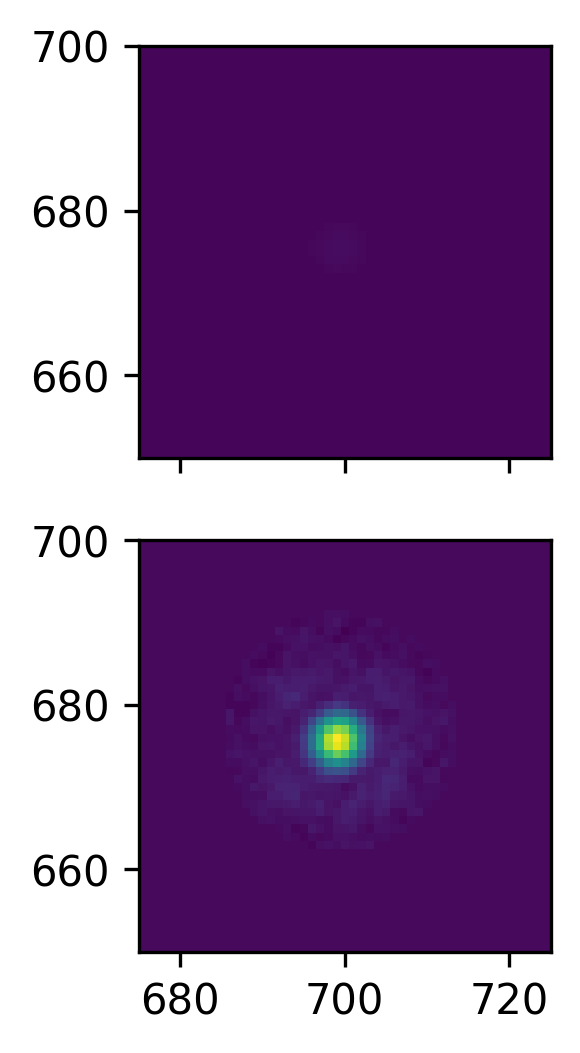

In [24]:
from gpu.losses import reduce_std_angle
loss_vis = wrapper(reduce_std_angle, nfwhm=3, debug=True, minimize='std')
%load_ext autoreload
%autoreload 2

for x, y_true in dataset:
    y_pred = model(x)
    val = loss_vis(y_true, y_pred)
    fig, axes = plt.subplots(2, 1, dpi=300, sharex=True, sharey=True)

    axes[0].imshow(y_true['cube'][0, 0])
#     axes[1].imshow(tf.reduce_sum(val, 1)[0])
    print(val[0].shape)
    axes[1].imshow(val[0, 0, ..., 0])
    axes[1].set_ylim(650, 700)
    axes[1].set_xlim(675, 725)

In [25]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=20,# min_delta=1e-5
)

tb = tf.keras.callbacks.TensorBoard(log_dir='./results/model', histogram_freq=0, write_images=True)

In [26]:
## %%time
hist = model.fit(dataset, epochs=100000, callbacks=[es, tb])

Layer FakeInjection was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/100000
std
1/1 [==============================] - 5s 5s/step - loss: 120445.8125
Epoch 2/100000
1/1 [==============================] - 0s 64ms/step - loss: 120095.6797
Epoch 3/100000
1/1 [==============================] - 0s 59ms/step - loss: 119745.6172
Epoch 4/100000
1/1 [==============================] - 0s 61ms/step - loss: 119395.6172
Epoch 5/100000
1/1 [==============================] - 0s 64ms/step - loss: 11

1/1 [==============================] - 0s 60ms/step - loss: 90753.4922
Epoch 88/100000
1/1 [==============================] - 0s 70ms/step - loss: 90415.4297
Epoch 89/100000
1/1 [==============================] - 0s 63ms/step - loss: 90077.6016
Epoch 90/100000
1/1 [==============================] - 0s 56ms/step - loss: 89739.9922
Epoch 91/100000
1/1 [==============================] - 0s 65ms/step - loss: 89402.6172
Epoch 92/100000
1/1 [==============================] - 0s 57ms/step - loss: 89065.4766
Epoch 93/100000
1/1 [==============================] - 0s 64ms/step - loss: 88728.5781
Epoch 94/100000
1/1 [==============================] - 0s 65ms/step - loss: 88391.9062
Epoch 95/100000
1/1 [==============================] - 0s 64ms/step - loss: 88055.4844
Epoch 96/100000
1/1 [==============================] - 0s 65ms/step - loss: 87719.3047
Epoch 97/100000
1/1 [==============================] - 0s 65ms/step - loss: 87383.3672
Epoch 98/100000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 59ms/step - loss: 60764.2773
Epoch 181/100000
1/1 [==============================] - 0s 65ms/step - loss: 60465.3984
Epoch 182/100000
1/1 [==============================] - 0s 66ms/step - loss: 60167.2539
Epoch 183/100000
1/1 [==============================] - 0s 64ms/step - loss: 59869.8555
Epoch 184/100000
1/1 [==============================] - 0s 60ms/step - loss: 59573.2070
Epoch 185/100000
1/1 [==============================] - 0s 55ms/step - loss: 59277.3281
Epoch 186/100000
1/1 [==============================] - 0s 62ms/step - loss: 58982.2148
Epoch 187/100000
1/1 [==============================] - 0s 65ms/step - loss: 58687.8945
Epoch 188/100000
1/1 [==============================] - 0s 66ms/step - loss: 58394.3633
Epoch 189/100000
1/1 [==============================] - 0s 65ms/step - loss: 58101.6406
Epoch 190/100000
1/1 [==============================] - 0s 63ms/step - loss: 57809.7383
Epoch 191/100000
1/1 [===========================

1/1 [==============================] - 0s 65ms/step - loss: 37800.5508
Epoch 274/100000
1/1 [==============================] - 0s 65ms/step - loss: 37628.7383
Epoch 275/100000
1/1 [==============================] - 0s 65ms/step - loss: 37458.9844
Epoch 276/100000
1/1 [==============================] - 0s 66ms/step - loss: 37291.2930
Epoch 277/100000
1/1 [==============================] - 0s 66ms/step - loss: 37125.6641
Epoch 278/100000
1/1 [==============================] - 0s 65ms/step - loss: 36962.1211
Epoch 279/100000
1/1 [==============================] - 0s 66ms/step - loss: 36800.6641
Epoch 280/100000
1/1 [==============================] - 0s 64ms/step - loss: 36641.3047
Epoch 281/100000
1/1 [==============================] - 0s 64ms/step - loss: 36484.0352
Epoch 282/100000
1/1 [==============================] - 0s 65ms/step - loss: 36328.8750
Epoch 283/100000
1/1 [==============================] - 0s 64ms/step - loss: 36175.8164
Epoch 284/100000
1/1 [===========================

1/1 [==============================] - 0s 64ms/step - loss: 29902.1953
Epoch 367/100000
1/1 [==============================] - 0s 65ms/step - loss: 29881.3926
Epoch 368/100000
1/1 [==============================] - 0s 66ms/step - loss: 29861.2656
Epoch 369/100000
1/1 [==============================] - 0s 67ms/step - loss: 29841.8008
Epoch 370/100000
1/1 [==============================] - 0s 65ms/step - loss: 29822.9746
Epoch 371/100000
1/1 [==============================] - 0s 65ms/step - loss: 29804.7695
Epoch 372/100000
1/1 [==============================] - 0s 65ms/step - loss: 29787.1699
Epoch 373/100000
1/1 [==============================] - 0s 63ms/step - loss: 29770.1621
Epoch 374/100000
1/1 [==============================] - 0s 64ms/step - loss: 29753.7207
Epoch 375/100000
1/1 [==============================] - 0s 54ms/step - loss: 29737.8359
Epoch 376/100000
1/1 [==============================] - 0s 64ms/step - loss: 29722.4922
Epoch 377/100000
1/1 [===========================

1/1 [==============================] - 0s 61ms/step - loss: 29336.1641
Epoch 460/100000
1/1 [==============================] - 0s 66ms/step - loss: 29335.6230
Epoch 461/100000
1/1 [==============================] - 0s 63ms/step - loss: 29335.1035
Epoch 462/100000
1/1 [==============================] - 0s 62ms/step - loss: 29334.6113
Epoch 463/100000
1/1 [==============================] - 0s 64ms/step - loss: 29334.1348
Epoch 464/100000
1/1 [==============================] - 0s 66ms/step - loss: 29333.6836
Epoch 465/100000
1/1 [==============================] - 0s 59ms/step - loss: 29333.2520
Epoch 466/100000
1/1 [==============================] - 0s 65ms/step - loss: 29332.8379
Epoch 467/100000
1/1 [==============================] - 0s 58ms/step - loss: 29332.4375
Epoch 468/100000
1/1 [==============================] - 0s 62ms/step - loss: 29332.0605
Epoch 469/100000
1/1 [==============================] - 0s 65ms/step - loss: 29331.6992
Epoch 470/100000
1/1 [===========================

1/1 [==============================] - 0s 64ms/step - loss: 29324.2910
Epoch 553/100000
1/1 [==============================] - 0s 65ms/step - loss: 29324.2832
Epoch 554/100000
1/1 [==============================] - 0s 65ms/step - loss: 29324.2773
Epoch 555/100000
1/1 [==============================] - 0s 57ms/step - loss: 29324.2715
Epoch 556/100000
1/1 [==============================] - 0s 64ms/step - loss: 29324.2695
Epoch 557/100000
1/1 [==============================] - 0s 64ms/step - loss: 29324.2617
Epoch 558/100000
1/1 [==============================] - 0s 59ms/step - loss: 29324.2598
Epoch 559/100000
1/1 [==============================] - 0s 67ms/step - loss: 29324.2539
Epoch 560/100000
1/1 [==============================] - 0s 66ms/step - loss: 29324.2500
Epoch 561/100000
1/1 [==============================] - 0s 62ms/step - loss: 29324.2461
Epoch 562/100000
1/1 [==============================] - 0s 64ms/step - loss: 29324.2402
Epoch 563/100000
1/1 [===========================

Text(0.5, 0, 'Iteration')

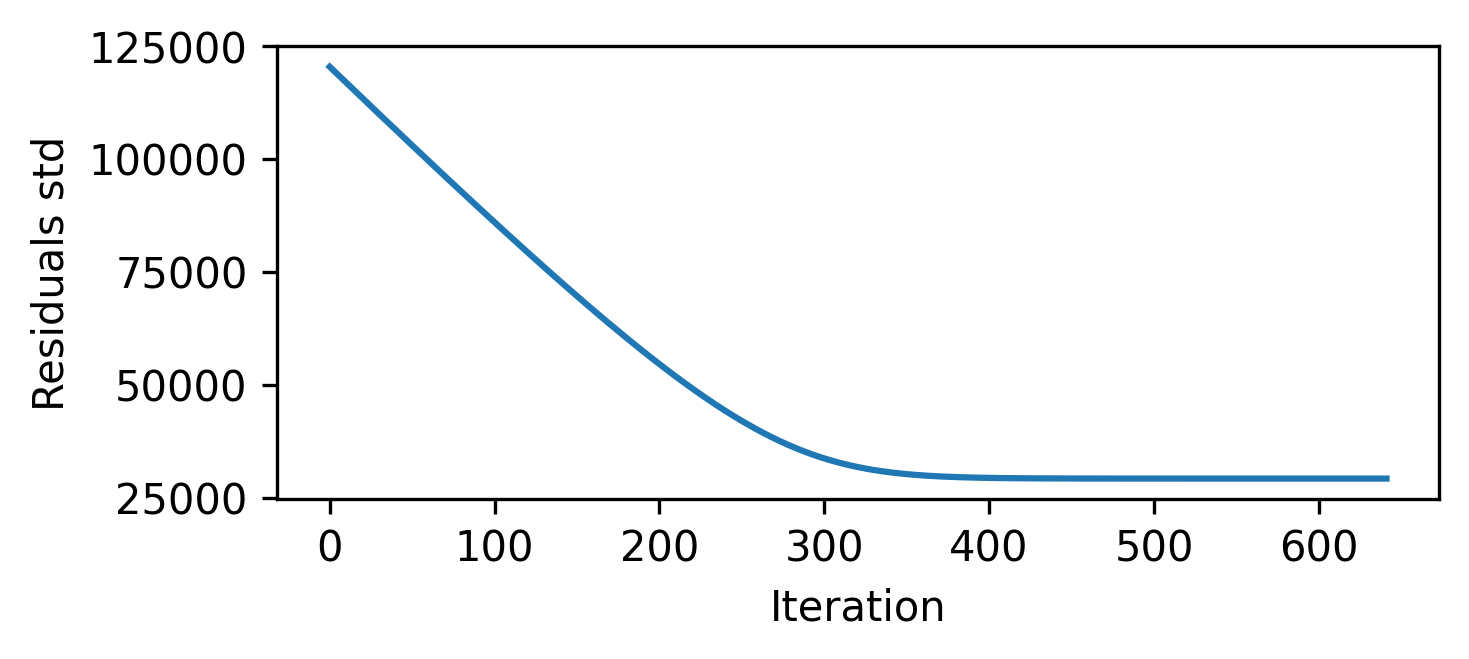

In [27]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(hist.history['loss'])
plt.ylabel('Residuals std')
plt.xlabel('Iteration')
# plt.yscale('log')

In [28]:
import gpu.fake_comp as tfnegfc
import tensorflow_addons as tfa
from vip_hci.fits import open_fits
import numpy as np

In [37]:
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 
if tf.rank(cube) < 4:
    cube = cube[None,...]
psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)
if psf.shape[-1] % 2 == 0:
    psf_reduced = psf[...,:-1,:-1]  
    psf = np.zeros_like(psf_reduced)
    for i, p_pos in enumerate(psf_reduced):
        for k, p_lambda in enumerate(p_pos):
            psf[i][k] = tfa.image.translate(p_lambda, [0.5, 0.5])
    
ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

Fits HDU-0 data successfully loaded. Data shape: (80, 1023, 1023)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


In [30]:
 model.trainable_variables

[<tf.Variable 'AngleBasedModel/xcoord:0' shape=(1, 1) dtype=float32, numpy=array([[250.21884]], dtype=float32)>,
 <tf.Variable 'AngleBasedModel/ycoord:0' shape=(1, 1) dtype=float32, numpy=array([[120.19564]], dtype=float32)>,
 <tf.Variable 'AngleBasedModel/flux:0' shape=(1, 1) dtype=float32, numpy=array([[-193.47392]], dtype=float32)>]

In [32]:
r_fguess = model.trainable_variables[0] #init_radius # 
t_fguess = model.trainable_variables[1] #init_theta # 
f_fguess = model.trainable_variables[2]

rot_theta = t_fguess # rotate angles 
rot_theta = tf.experimental.numpy.deg2rad(rot_theta)

x_fguess = tf.multiply(r_fguess, tf.cos(rot_theta)) + tf.cast(cube.shape[-1]/2, tf.float32)
y_fguess = tf.multiply(r_fguess, tf.sin(rot_theta)) + tf.cast(cube.shape[-2]/2, tf.float32) 

In [33]:
from vip_hci.fm.negfc_fmerit import cube_inject_companions

In [34]:
for p1, p2, name in zip([init_theta, init_radius, init_flux], 
                  [t_fguess.numpy(), r_fguess.numpy(), f_fguess.numpy()],
                  ['theta : ', 'radius : ', 'flux: ']):
    
    for v1, v2 in zip(p1, p2):
        try:
            print('init', name, v1.numpy(),' - final',name, v2)
        except:
            print('init', name, v1,' - final',name, v2)


init theta :  120.19564  - final theta :  [120.19564]
init radius :  250.21884  - final radius :  [250.21884]
init flux:  130.09562393366  - final flux:  [-193.47392]


In [35]:
%%time
adi_image = tfnegfc.apply_adi(cube[0], 
                              rot_ang, 
                              out_size=cube[0].shape, 
                              ncomp=2, 
                              derotate='tf', 
                              return_cube=False)

injected_cube = tfnegfc.inject_fake(x_fguess[0], 
                                    y_fguess[0], 
                                    f_fguess[0], 
                                    np.zeros_like(cube[0]), 
                                    patch, 
                                    rot_ang)

adi_image_fake = tfnegfc.apply_adi(injected_cube, 
                                   rot_ang, 
                                   out_size=injected_cube.shape, 
                                   ncomp=2, 
                                   derotate='tf', 
                                   return_cube=False)

CPU times: user 1.32 s, sys: 1.39 s, total: 2.71 s
Wall time: 2.72 s


(700.0, 800.0)

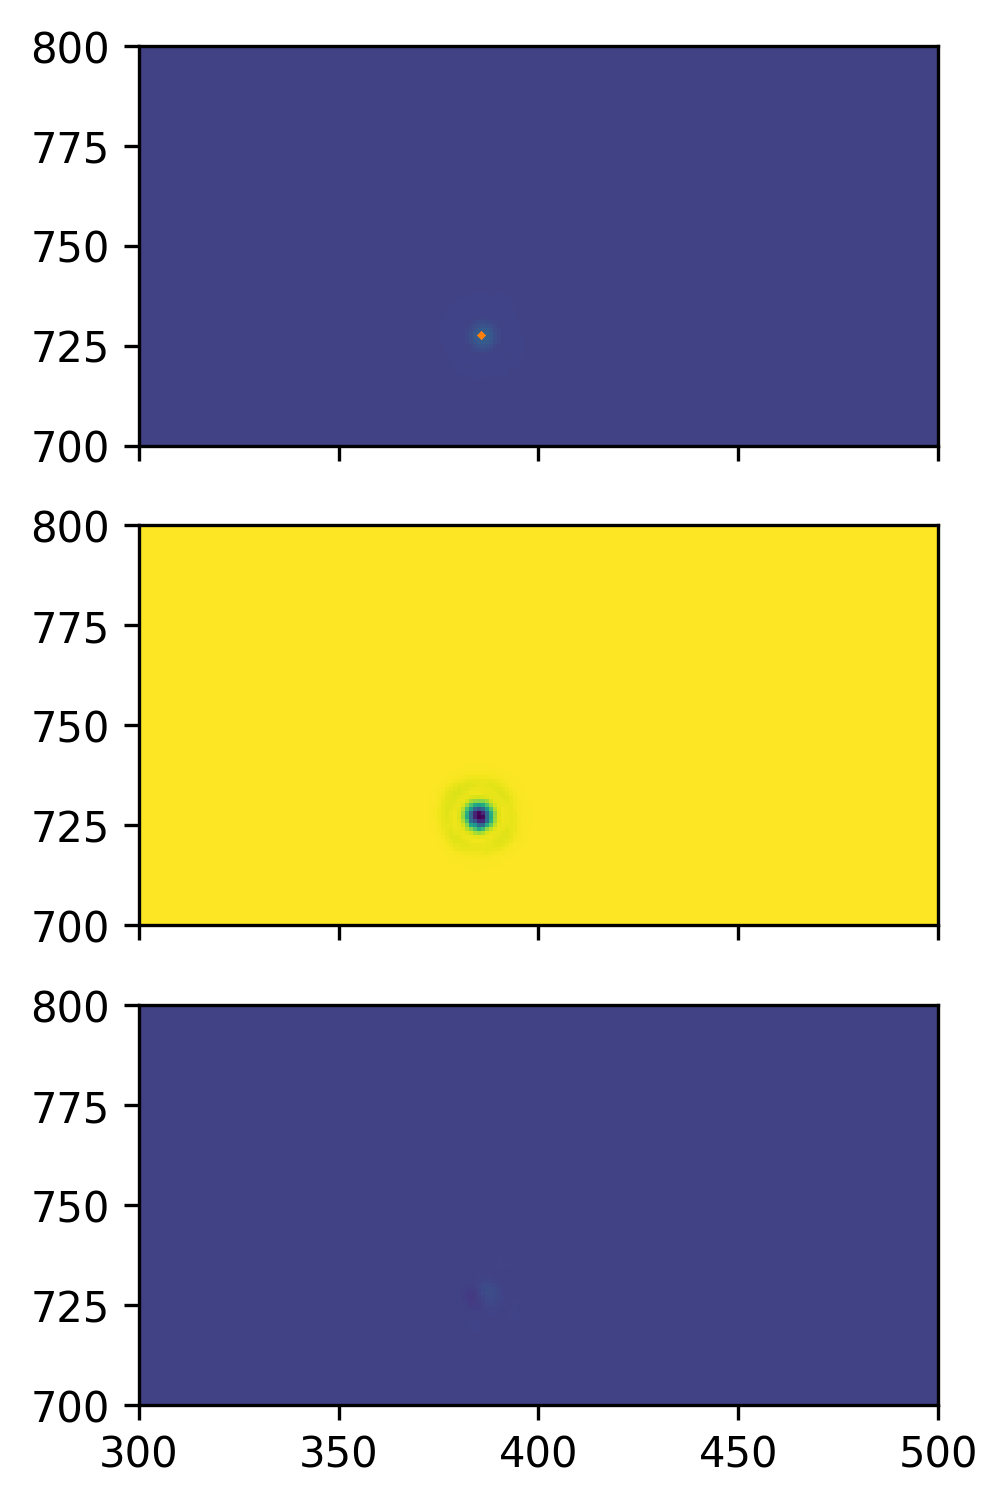

In [36]:
fig, axes = plt.subplots(3, 1, dpi=300, figsize=(6,6), sharex=True, sharey=True)
axes[0].imshow(adi_image)
axes[0].scatter(x_fguess[0], y_fguess[0], marker='x', s=1)
axes[0].scatter(init_xy[:, 0][0], init_xy[:, 1][0], marker='x', s=1)

axes[1].imshow(adi_image_fake)
axes[2].imshow(adi_image+adi_image_fake)
axes[2].set_xlim(300,500)
axes[2].set_ylim(700,800)

(500.0, 525.0)

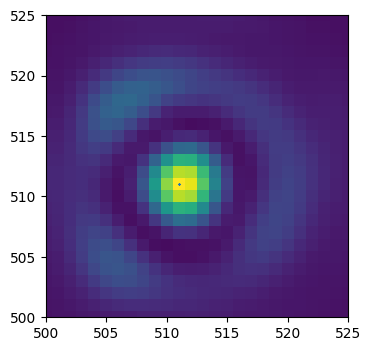

In [49]:
plt.figure(dpi=100)

plt.imshow(cube[0, 0])

plt.scatter(cube[0, 0].shape[-1]//2., cube[0, 0].shape[-1]//2, s=1, marker='x')

plt.ylim(500, 525)
plt.xlim(500, 525)